# Using a robust data pipelining tool in R to build a reproducible hurricane data visualization with multi-agency water data

## Context
### Purpose
The purpose is to demonstrate how to use the `targets` R package (https://docs.ropensci.org/targets/) to construct a reproducible data pipeline that integrates and analyzes data from diverse environmental sources to investigate flooding during [Hurricane Harvey](https://doi.org/10.3133/sir20185070), which first made landfall in the United States in south-central Texas on August 25, 2017 as a category 4 hurricane.

### Description
The main features of this use case involve fetching, integrating/processing and visualizing water data from three distinct public sources: [USGS (United States Geoleogical Survey)](https://www.usgs.gov/) stream water level (also referred to as gage or stage) data, [NWS (National Weather Service)](https://www.weather.gov/) flood stage data, and [NHC (National Hurricane Center)](https://www.nhc.noaa.gov/) storm track data for Hurricane Harvey, along with U.S. state boundary data from [Natural Earth](https://www.naturalearthdata.com/). The pipeline will ensure that any changes in the raw data or processing functions only trigger a rerun of the necessary downstream steps, promoting efficiency and reproducibility.

### Highlights
- Fetch and integrate diverse data: USGS stage, NWS flood, NHC storm track and U.S. state boundary data.
- Automate data workflow: Use `targets` for a structured and reproducible workflow.
- Investigate flood event: Focus analysis on the timing and magnitude of flooding during Hurricane Harvey.
- Efficient updates: Only re-run parts of the pipeline affected by data or code changes.

This tutorial is extended from materials and insights shared by Abner Bogan and Lindsay Platt, Environmental Data Scientists at the [Consortium of Universities for the Advancement of Hydrologic Science, Inc. (CUAHSI)](https://www.cuahsi.org/), for the [Earth Science Information Partners (ESIP)](https://www.esipfed.org/) community. For more detail on this topic, you can read the original post:
[Guest Blog: Reproducible data pipelines in R with {targets}](https://www.esipfed.org/guest-blog-reproducible-data-pipelines-in-r-with-targets/).

## Summary of workflow and motivation for using `targets`

The workflow is organized into three phases: **fetch** (first phase), **process** (second phase) and **visualize** (third phase). _**The primary outputs of the workflow are an interactive and static visualization of the flooding impacts of Hurricane Harvey over time.**_ A directory structure of the workflow-related code files is below:

```R
Directory structure:
└── root/
    ├── 01_fetch.R
    ├── 02_process.R
    ├── 03_visualize.R
    ├── _targets.R
    ├── 01_fetch/
    │   ├── src/
    │   │   ├── download_nhc_best_track.R
    │   │   ├── download_nwis_site_info.R
    │   │   ├── download_nwis_stage_data.R
    │   │   ├── download_nws_conversion.R
    │   │   └── download_nws_data.R
    ├── 02_process/
    │   └── src/
    │       └── process_helpers.R
    ├── 03_visualize/
        └── src/
            ├── visualize_harvey_map.R
            └── visualize_hydrographs.R
```

To make this workflow more readable, the chronological number of the phase execution is included in the file and folder names (e.g., `01_fetch.R`), and the scripts are named and written for doing distinct tasks in the workflow (e.g., the `01_fetch/download_nwis_stage_data.R` script contains functions to download the time-series stage data from the [National Water Information System (NWIS)](https://waterdata.usgs.gov/nwis) at defined USGS gage sites). Even with this structured setup, one would likely still have a few important questions:
- How would you go about running this workflow? Where do you start and what are the order of operations?
- What parts of the workflow would you re-run if changes are made to the inputs or code files? 
- How would you reliabily track changes to the workflow as it increases in complexity?

The `targets` package makes answering these questions much easier, less manual and less error-prone! To start, you can look at the [_targets.R](_targets.R) file for a more detailed description of the workflow, what it does and how to execute it. The next sections are intended to provide practical examples of how to use `targets` and demonstrate its capabilities.

## Load libraries

In [1]:
# load the targets library (version 1.11.4)
library(targets)
# load the magick library for displaying static images
library(magick)
# suppress warnings
options(warn = -1)

Linking to ImageMagick 6.9.11.60
Enabled features: fontconfig, freetype, fftw, heic, lcms, pango, webp, x11
Disabled features: cairo, ghostscript, raw, rsvg



Using 4 threads



## Inspect and run pipeline

### Visualizing the Pipeline Network

A key advantage of `targets` is the ability to easily visualize the workflow. This interactive graph (generated by `targets::tar_visnetwork()`) clearly shows how each "target" (data output or derived product) depends on the previous steps and functions. This transparency is crucial for collaboration and maintaining complex projects.

```{note}
**The pipeline network below is interactive!** You can scroll/zoom and click on targets to select them and view dependency details, as well as drag nodes to rearrange the network.
```

```{attention} At the moment, full display of the interactive plots is only supported through execution of the notebook locally or in Binder.
```

In [2]:
# this is an interactive graphic showing the pipeline network
tar_visnetwork()

HTML widgets cannot be represented in plain text (need html)

### Running the Pipeline: The First Build

To execute the entire workflow, we use the `targets::tar_make()` command.

The first time `targets::tar_make()` is run, it executes every target (downloading data, processing, and generating the final graphics). Unlike a single R script that must be re-executed entirely, targets intelligently checks the status of every component (data, code, and dependencies) for changes. All `targets` pipeline artifacts are stored in the local cache (`_targets` folder) which is crucial for not only highly efficient re-runs, but for debugging as well.

In [3]:
# execute the pipeline; all targets will run for the first time
tar_make()

+ p1_site_info dispatched
Requesting:
https://api.waterdata.usgs.gov/ogcapi/v0/collections/monitoring-locations/items?f=json&lang=en-US&limit=10000
✔ p1_site_info completed [2.1s, 3.11 kB]
+ p1_nws_table dispatched
Rows: 826 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "|"
chr (7): X1, X2, X3, X4, X5, X6, X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 268 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "|"
chr (7): X1, X2, X3, X4, X5, X6, X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
✔ p1_nws_table completed s, 36.47 kB]
+ p1_site_data dispatched
Requesting:
https://api.waterdata.usgs.gov/ogcapi/v0/collections/daily/items?f=json&lang=en-US&time=2017-

### Inspect pipeline outputs

To see the final products of our workflow -- namely the hurricane and gage height/flooding stage visualizations, we use the `targets::tar_read()` function, where the input arguement is the name of the target that we are interested in returning. Note that we used a prefix indicating the workflow phase number for both the targets in this pipeline (e.g., `p1_site_data`, `p2_harvey_pts`, `p3_leaflet_map`) along with the folders in this workspace (e.g., `01_fetch`, `02_process`, `03_visualize`).

```{note}
**The `leaflet` map below is interactive!** You can scroll/zoom and click on USGS gage site markers to view site information (e.g., station name).
```

HTML widgets cannot be represented in plain text (need html)

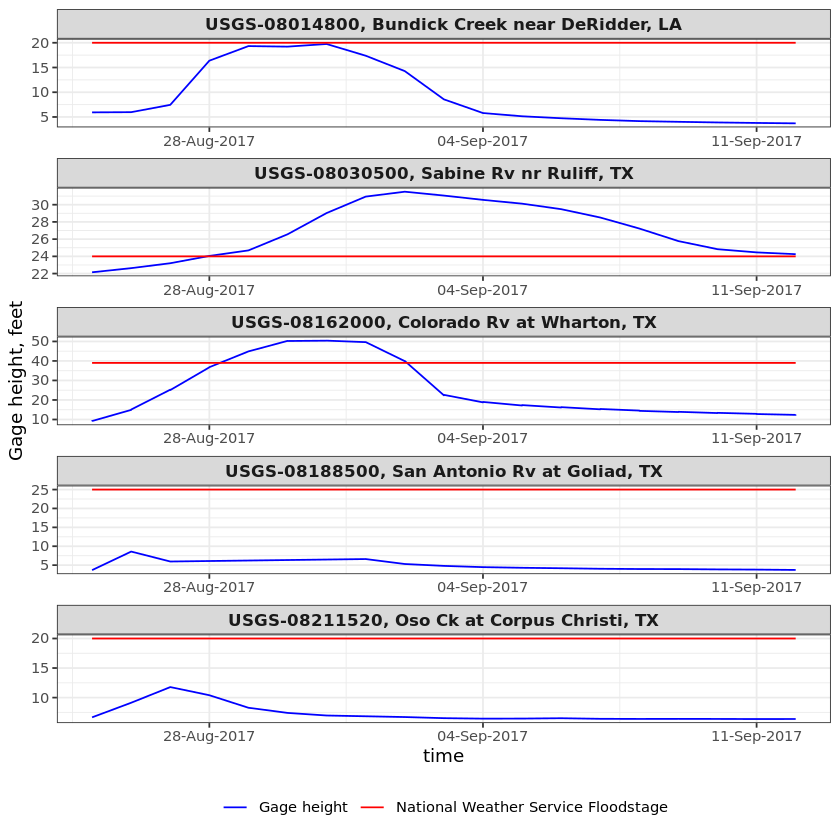

In [4]:
# this target represents the interactive leaflet map showing the hurricane track over time along with the USGS gage sites for reference
tar_read(p3_leaflet_map)
# this target represents the plot made with ggplot showing the gage height over time (hydrograph) in blue along with the minor flood stage data for reference in red across all analyzed USGS gage sites
tar_read(p3_hydrograph_plot)

### Making Updates and Leveraging Rebuild Capabilities

One of the most powerful features of `targets` is its ability to handle changes efficiently. If this entire analysis were written in a single script, changing one input parameter (e.g., the site ID or a filter date) would force you to re-run the entire script, requiring a full re-download and re-process of all raw data.

With `targets`, only the targets that are affected by the upstream change are re-run. The results of all unaffected steps are loaded instantly from the cache. This efficient rebuild capability saves significant time, computational resources, and unnecessary network bandwidth.

This emphasis on linkages and rebuild capabilities is the main benefit of using a `targets` pipeline over a monolithic script.

#### Example: Simulating a Workflow Update

To demonstrate, let's simulate a change in an input parameter. For instance, imagine we change the input USGS gage sites parameter (represented by `harvey_sites` in the `_targets.R` file) to look at another nearby gage.

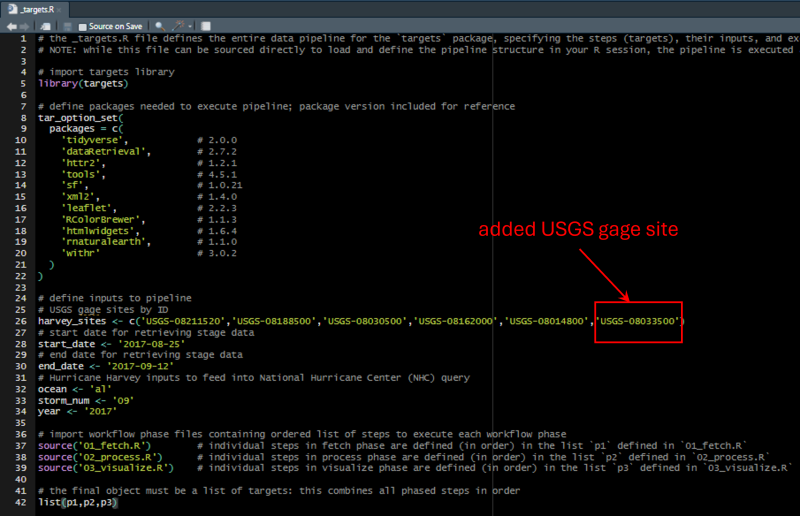

In [5]:
# show edits to _targets.R file
image_read('images/workflow_updates.png') %>% image_scale("800") %>% print(info = FALSE)

```{note}
Since we cannot edit the underlying `_targets.R` file interactively here, we will use the `targets::tar_invalidate()` function to force the re-run of the targets associated with the `harvey_sites` object defined in the `_targets.R` to simulate a change in its dependency. Then, we will run `targets::tar_visnetwork()` and `targets::tar_make()` again.
```

In [6]:
# simulate a change by invalidating a key object defined in the _targets.R main script outlining the receipe for the pipeline; this tells `targets` that the downstream dependencies need to be rebuilt.
# we need to explicity invalidate the p1_site_data target as well to simulate this change
tar_invalidate(c('harvey_sites','p1_site_data'))
# visualize the workflow
tar_visnetwork()
# run the pipeline again
tar_make()

HTML widgets cannot be represented in plain text (need html)

+ p1_site_data dispatched
Requesting:
https://api.waterdata.usgs.gov/ogcapi/v0/collections/daily/items?f=json&lang=en-US&time=2017-08-25%2F2017-09-12&limit=10000
✔ p1_site_data completed [1.7s, 5.91 kB]
+ p1_site_data_csv dispatched
✔ p1_site_data_csv completed s, 21.00 kB]
+ p2_stage_flooding_data dispatched
✔ p2_stage_flooding_data completed s, 5.55 kB]
+ p3_hydrograph_plot dispatched
✔ p3_hydrograph_plot completed s, 468.03 kB]
+ p3_hydrograph_plot_svg dispatched
[1] "Hydrograph plots saved to 03_visualize/out/hydrograph_plot.svg"
✔ p3_hydrograph_plot_svg completed s, 31.86 kB]
✔ ended pipeline [3.2s, 5 completed, 11 skipped]


Notice that the output from the second `targets::tar_make()` call only executes a subset of the total targets. The targets that were unaffected (like the National Hurricane Center data download, which doesn't depend on the USGS site ID) are loaded directly from the cache.

This is the core benefit of using `targets`: a robust, efficient, and reproducible data workflow that rebuilds only what is necessary.

## Summary
- We leveraged the `targets` R package to build a reproducible data pipeline for a complex environmental analysis.
- The analysis integrated diverse water data sources across multiple agencies related to Hurricane Harvey flooding, including USGS stage data, NWS flooding data, and NHC hurricane track data.
- We demonstrated how `targets` tracks dependencies to ensure that only the steps ("targets") affected by changes in code or data are efficiently rebuilt, saving time and reducing errors.
- The modular structure of the `targets` pipeline, using separate functions and organized files, was shown to enhance project organization, collaboration, and maintainability.

## Citing this Notebook

Please see [CITATION.cff](https://github.com/eds-book/2dd74dfa-d87d-442f-bea1-a19c8953f66e/blob/main/CITATION.cff) for the full citation information. The citation file can be exported to APA or BibTex formats (learn more [here](https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/about-citation-files)).

## Additional information

**Software**: Information on the `targets` package used in this tutorial is below:
- Landau, W. M., (2021). The targets R package: a dynamic Make-like function-oriented pipeline toolkit for reproducibility and high-performance computing. Journal of Open Source Software, 6(57), 2959. https://doi.org/10.21105/joss.02959

**Dataset**: Information on the datasets accessed and used in this tutorial is below:

* _**USGS Stream Gages (Real-time stream stage/water level):**_
    - **Access Software:** `dataRetrieval`: R package for retrieving water data from US federal sources. U.S. Geological Survey Software Release. DOI: https://doi.org/10.32614/CRAN.package.dataRetrieval. Accessed November 14, 2025.
        - _NOTE:_ this workflow uses functions from the modern USGS Water API outlined here: https://water.code-pages.usgs.gov/dataRetrieval/articles/read_waterdata_functions.html
* _**NWS Flooding Data (Flood Stage):**_
    - **Access software:** U.S. National Weather Service API: https://api.weather.gov/. Accessed November 14, 2025.
        - GitHub link: https://github.com/weather-gov/api
* _**NHC Hurricane Track (Hurricane Harvey):**_
    - **Data Source:** Official best track and intensity data for Hurricane Harvey (AL092017) from the NOAA National Hurricane Center (NHC): https://www.nhc.noaa.gov/gis/archive_besttrack.php. Accessed November 14, 2025.
* _**U.S. State Boundaries:**_
    - **Access software:** `rnaturalearth`: World Map Data from Natural Earth; maintained by Philippe Massicotte. DOI: https://doi.org/10.32614/CRAN.package.rnaturalearth. Accessed November 14, 2025.
        - GitHub link: https://github.com/ropensci/rnaturalearth

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [7]:
print(paste0('Last tested: ',Sys.Date()))
print('Notebook repository version: v2025.12.3')

[1] "Last tested: 2025-12-14"


[1] "Notebook repository version: v2025.12.3"
